# Understanding Resnets uTh 

In this notebook we will augment the mnist datasets in different colors and what not and see how well it can learn. We also want to understand what the innner convolutions are learning. 

In [25]:
## Imports
import torch
import torchvision ## Contains some utilities for working with the image data
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
#%matplotlib inline
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Credit [1]

In [10]:
!ls

Data_Exploration_Allium.ipynb  Training_ResNet_Carnation.ipynb
Resnet_Birdopar.ipynb	       dog.jpg
Tabular_Data_Cleaning.ipynb    imagenet_classes.txt


In [11]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=True, download=False) )

In [12]:
dataset = MNIST(root = '../data/', download = False) # IMP: SET DOWNLOAD TO FALSE SINCE WE HAVE THE DATASET ALREADY 
print(len(dataset))

60000


Label: 3


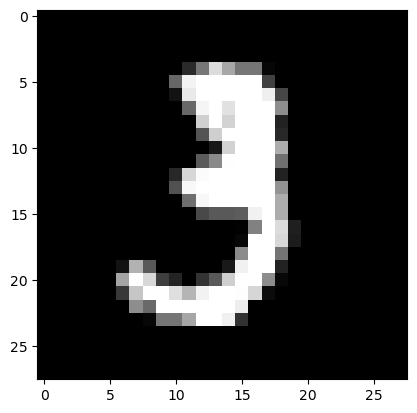

In [13]:
image, label = dataset[10]
plt.imshow(image, cmap = 'gray')
print('Label:', label)

In [14]:
# https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html
type(dataset)

torchvision.datasets.mnist.MNIST

In [15]:
mnist_dataset = MNIST(root = '../data/', train = True, transform = transforms.ToTensor())
print(mnist_dataset) # pull the train images 


Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [16]:
image_tensor, label = mnist_dataset[0]
print(image_tensor.shape, label)

torch.Size([1, 28, 28]) 5


tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


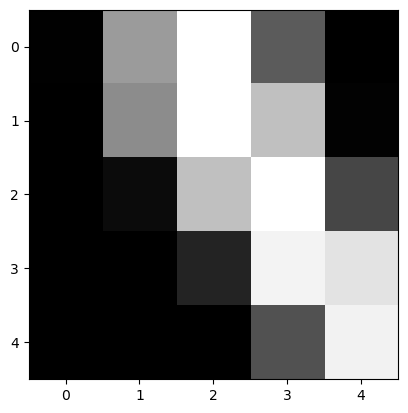

In [17]:
print(image_tensor[:,10:15,10:15])
print(torch.max(image_tensor), torch.min(image_tensor))
plt.imshow(image_tensor[0,10:15,10:15],cmap = 'gray')

In [17]:
train_data, validation_data = random_split(mnist_dataset, [50000, 10000])
## Print the length of train and validation datasets
print("length of Train Datasets: ", len(train_data))
print("length of Validation Datasets: ", len(validation_data))

length of Train Datasets:  50000
length of Validation Datasets:  10000


In [18]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)

# Empty Resnet
- Now that we have the MNIST dataset downloaded lets train the resnet with it
- Credit [2


## ResNet Basics 
The ResNet Neural Network is a deep learning cnn network. There are many different variants of it that have been pre-trained on ImageNet. A popular resnet hyperparameter is the depth of the network, ie how many layers it has. The pretrained ones provides by Pytorch have values ranging from 18 to 152. (uncontinuous). 

Two popular metric for evaluating model performance is the Top-1 and Top-5 errors. Top 1 is more strict in requiring our networks prediction to be exactly that of the label, whereas Top-5 allows it to be within the top 5. 

Based on a PyTorch blog post, error rate appears to decrease as the model gets deeper but there does appear to be a plateu. 


# Training an Empty Resnet
In this part of the notebook I will attempt to train the an empty resnet on the MNIST dataset. However before we can do anything we must understand a few things. The MNIST dataset is of a smaller resolution than what the RESNET is, hence we must upsample. We can simply split pixels and give them the sample value. Also there are three channels required by the ResNet Model. Hence let's just create three channels anyways by copying the values over



Some questions: 
- CNNs perform well on object detection and classification. Classification and detection are two different problems. If we can detect things does that possible lead to a better model?
- Let's say we have a image set that is 100 by 100 pixels. The image set contains shapes, such as squares, triangles, and circles. We model this as a classificatoin problem with 3 classes. Imagine that most of the training set includes shapes that are of radius 40. We train a resnet on this model. Additionally, all of the shapes are centered. Next up in the testing set we have a distribution that looks similar to the training set, however the radius is 20 and it appears centered in the top right quadrant. Will the model still perform well in classification?

In [4]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None) # Lets load the model we will train 

Using cache found in /usr4/cs640/rakin374/.cache/torch/hub/pytorch_vision_v0.10.0


In [5]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.models import ResNet

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def data_loader(data_dir,
                    batch_size,
                    random_seed=42,
                    valid_size=0.1,
                    shuffle=True,
                    test=False):

        normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )

        # define transforms
        transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.Grayscale(num_output_channels=3),
                transforms.ToTensor(),
                normalize,
        ])

        if test:
            dataset = datasets.MNIST(
              root=data_dir, train=False,
              download=False, transform=transform,
            )

            data_loader = torch.utils.data.DataLoader(
                dataset, batch_size=batch_size, shuffle=shuffle
            )

            return data_loader

        # load the dataset
        train_dataset = datasets.MNIST(
            root=data_dir, train=True,
            download=False, transform=transform,
        )

        valid_dataset = datasets.MNIST(
            root=data_dir, train=True,
            download=False, transform=transform,
        )

        num_train = len(train_dataset)
        indices = list(range(num_train))
        split = int(np.floor(valid_size * num_train))

        if shuffle:
            np.random.seed(42)
            np.random.shuffle(indices)

        train_idx, valid_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=train_sampler)

        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=batch_size, sampler=valid_sampler)

        return (train_loader, valid_loader)
train_loader, valid_loader = data_loader(data_dir='../data/',
                                     batch_size=64)

test_loader = data_loader(data_dir='../data/',
                          batch_size=64,
                          test=True)

In [8]:
class ResNet2(nn.Module):
        def __init__(self, block, layers, num_classes = 10):
            super(ResNet2, self).__init__()
            self.inplanes = 64
            self.conv1 = nn.Sequential(
                            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                            nn.BatchNorm2d(64),
                            nn.ReLU())
            self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
            self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
            self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
            self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
            self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
            self.avgpool = nn.AvgPool2d(7, stride=1)
            self.fc = nn.Linear(512, num_classes)

        def _make_layer(self, block, planes, blocks, stride=1):
            downsample = None
            if stride != 1 or self.inplanes != planes:

                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(planes),
                )
            layers = []
            layers.append(block(self.inplanes, planes, stride, downsample))
            self.inplanes = planes
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)

        def forward(self, x):
            x = self.conv1(x)
            x = self.maxpool(x)
            x = self.layer0(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)

            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)

            return x

In [9]:
class ResidualBlock(nn.Module):
        expansion = 1
        def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
            super(ResidualBlock, self).__init__()
            
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())
            self.conv2 = nn.Sequential(
                            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                            nn.BatchNorm2d(out_channels))
            self.downsample = downsample
            self.relu = nn.ReLU()
            self.out_channels = out_channels

        def forward(self, x):
            residual = x
            out = self.conv1(x)
            out = self.conv2(out)
            if self.downsample:
                residual = self.downsample(x)
            out += residual
            out = self.relu(out)
            return out

In [12]:

num_classes = 10
num_epochs = 20
batch_size = 16
learning_rate = 0.01

model = ResNet2(ResidualBlock, [3, 4, 6, 3]).to(device)

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

#Train the model
total_step = len(train_loader)

In [19]:
import gc
total_step = len(train_loader)

for epoch in range(num_epochs):
    print(f"Epoch : {epoch} " ) 
    for i, (images, labels) in enumerate(train_loader):  
        
        #Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss.item()))

    #Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            rocplot(labels, outputs)
        del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

Epoch : 0 
Epoch [1/20], Loss: 0.1129
Accuracy of the network on the 5000 validation images: 98.38333333333334 %
Epoch : 1 
Epoch [2/20], Loss: 0.0028
Accuracy of the network on the 5000 validation images: 98.73333333333333 %
Epoch : 2 
Epoch [3/20], Loss: 0.0021
Accuracy of the network on the 5000 validation images: 98.86666666666666 %
Epoch : 3 
Epoch [4/20], Loss: 0.0018
Accuracy of the network on the 5000 validation images: 99.16666666666667 %
Epoch : 4 
Epoch [5/20], Loss: 0.0019
Accuracy of the network on the 5000 validation images: 99.13333333333334 %
Epoch : 5 
Epoch [6/20], Loss: 0.0150
Accuracy of the network on the 5000 validation images: 99.16666666666667 %
Epoch : 6 
Epoch [7/20], Loss: 0.0047
Accuracy of the network on the 5000 validation images: 99.16666666666667 %
Epoch : 7 
Epoch [8/20], Loss: 0.0067
Accuracy of the network on the 5000 validation images: 99.3 %
Epoch : 8 
Epoch [9/20], Loss: 0.0245
Accuracy of the network on the 5000 validation images: 99.4333333333333

In [20]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.0.weight 	 torch.Size([64, 3, 7, 7])
conv1.0.bias 	 torch.Size([64])
conv1.1.weight 	 torch.Size([64])
conv1.1.bias 	 torch.Size([64])
conv1.1.running_mean 	 torch.Size([64])
conv1.1.running_var 	 torch.Size([64])
conv1.1.num_batches_tracked 	 torch.Size([])
layer0.0.conv1.0.weight 	 torch.Size([64, 64, 3, 3])
layer0.0.conv1.0.bias 	 torch.Size([64])
layer0.0.conv1.1.weight 	 torch.Size([64])
layer0.0.conv1.1.bias 	 torch.Size([64])
layer0.0.conv1.1.running_mean 	 torch.Size([64])
layer0.0.conv1.1.running_var 	 torch.Size([64])
layer0.0.conv1.1.num_batches_tracked 	 torch.Size([])
layer0.0.conv2.0.weight 	 torch.Size([64, 64, 3, 3])
layer0.0.conv2.0.bias 	 torch.Size([64])
layer0.0.conv2.1.weight 	 torch.Size([64])
layer0.0.conv2.1.bias 	 torch.Size([64])
layer0.0.conv2.1.running_mean 	 torch.Size([64])
layer0.0.conv2.1.running_var 	 torch.Size([64])
layer0.0.conv2.1.num_batches_tracked 	 torch.Size([])
layer0.1.conv1.0.weight 	 torch.Size([64, 64, 3, 3])
laye

In [25]:
torch.save(model.state_dict(), "../models/rescarnation") # saves model 

In [10]:
model = ResNet2(ResidualBlock, [3, 4, 6, 3]).to(device)
model.load_state_dict(torch.load('../models/rescarnation', weights_only=True)) # reload model 
model.eval()

ResNet2(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

# Model Performace 

In [11]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import multilabel_confusion_matrix

def roc_plot(y_true,y_pred):
    # Calculate ROC curve
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred) 
    roc_auc = auc(fpr, tpr)
    # Plot the ROC curve
    plt.figure()  
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [16]:
def mlcm_plot(y_true, y_pred):
    mlcm = multilabel_confusion_matrix(y_true, y_pred)
    
    # Plot each class' confusion matrix
    fig, axes = plt.subplots(1, mlcm.shape[0], figsize=(15, 5))
    for i, (cm, ax) in enumerate(zip(mlcm, axes)):
        ax.matshow(cm, cmap="Blues")
        ax.set_title(f"Class {i}")
        for (x, y), value in np.ndenumerate(cm):
            ax.text(y, x, f"{value}", va="center", ha="center")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.xaxis.set_label_position("bottom")
        ax.set_xticks(range(2))
        ax.set_yticks(range(2))
    
    plt.tight_layout()
    plt.show()

In [51]:
#Validation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():
    correct = 0
    total = 0
    full_labels = torch.empty(0, dtype=torch.int, device=device)
    full_preds = torch.empty(0, dtype=torch.int, device=device)
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        predicts = []
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        full_labels = torch.cat((full_labels, predicted), dim=0)
        full_preds = torch.cat((full_preds, labels), dim=0)
        #print(outputs)
        #mlcm_plot(labels, outputs)
    del images, labels, outputs

    

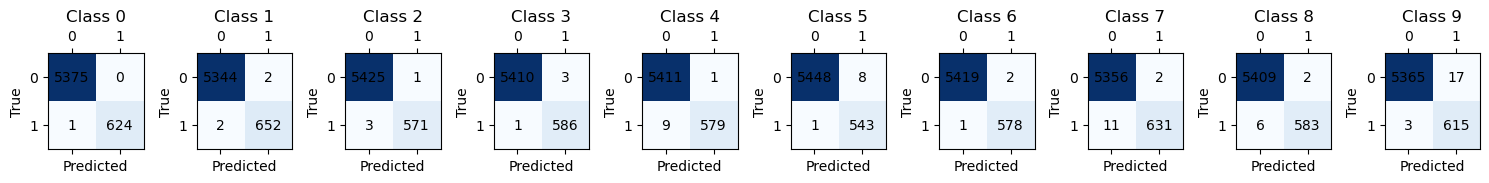

In [56]:

mlcm_plot(full_labels.cpu(),full_preds.cpu())

# Credits 

- https://www.geeksforgeeks.org/how-to-plot-roc-curve-in-python/
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html
- https://www.digitalocean.com/community/tutorials/writing-resnet-from-scratch-in-pytorch#loading-the-dataset
- https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_resnet.ipynb
- https://www.kaggle.com/code/geekysaint/solving-mnist-using-pytorch
- https://debuggercafe.com/training-resnet18-from-scratch-using-pytorch/

# Stale, Garabage, etc! 

In [83]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, name=None):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='tab:blue', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='tab:red', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join('outputs', name+'_accuracy.png'))
    
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='tab:blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='tab:red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join('outputs', name+'_loss.png'))

In [84]:
import torch
from tqdm import tqdm
# Training function.
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    # epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

def validate(model, testloader, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [87]:
# Learning and training parameters.
from torch import optim
epochs = 20
batch_size = 64
learning_rate = 0.01
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# Optimizer.
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# Loss function.
criterion = nn.CrossEntropyLoss()

21,298,314 total parameters.
21,298,314 training parameters.


In [92]:
import os
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(
        model, 
        train_loader, 
        optimizer, 
        criterion,
        device
    )
    valid_epoch_loss, valid_epoch_acc = validate(
        model, 
        valid_loader, 
        criterion,
        device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    
# Save the loss and accuracy plots.
save_plots(
    train_acc, 
    valid_acc, 
    train_loss, 
    valid_loss, 
    name="HELLO
)
print('TRAINING COMPLETE')

SyntaxError: unterminated string literal (detected at line 35) (557899498.py, line 35)

NameError: name 'os' is not defined

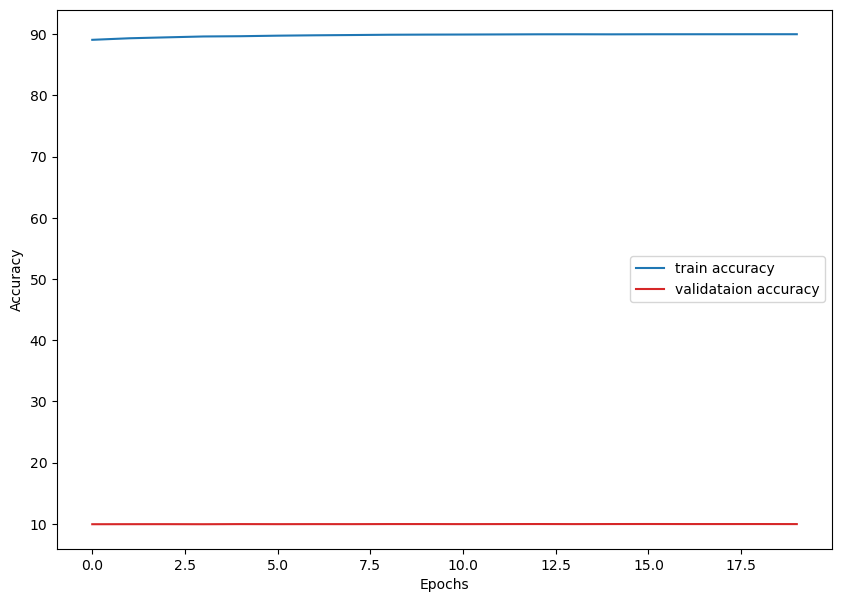

In [90]:
save_plots(
    train_acc, 
    valid_acc, 
    train_loss, 
    valid_loss, 
    name="HELLO"
)
print('TRAINING COMPLETE')